Week 3 - Continued EDA from week 2. I'll be exploring the State dataset. Definitely interested in looking at variables with respect to time, so we'll have to work on creating a Date variable.

Setup file contains a nice pip install function that reads the requirements.txt file. Should hopefully get rid of any problems with uninstalled packages/modules.

In [1]:
# Standard Setup Import
from _Setup import *

Installing dependencies from requirements.txt...
All dependencies installed successfully.


In [2]:
# Import state-level data
state_df = pd.read_csv(state_data_csv_path)
state_df.head()

,Fiscal Year,Month Grouping,Month (abbv),Land Border Region,State,Demographic,Citizenship,Title of Authority,Encounter Count
0,2022,FYTD,DEC,Northern Land Border,AK,Single Adults,CANADA,Title 8,3
1,2022,FYTD,DEC,Northern Land Border,ID,Single Adults,CANADA,Title 8,6
2,2022,FYTD,DEC,Northern Land Border,ID,Single Adults,"CHINA, PEOPLES REPUBLIC OF",Title 8,1
3,2022,FYTD,DEC,Northern Land Border,ID,Single Adults,OTHER,Title 8,2
4,2022,FYTD,DEC,Northern Land Border,ME,Accompanied Minors,CANADA,Title 42,1


2025 is the only one that has this tag "2025 (FYTD)" to note that fiscal year 2025 is not through yet. As we only care about the FY, we can replace the value with just 2025

In [3]:
state_df.replace(to_replace="2025 (FYTD)", value=2025, inplace=True)
state_df.replace(to_replace='2024', value=2024, inplace=True)
print(state_df['Fiscal Year'].unique())

['2022' '2023' 2024 2025 '2020' '2021']


Can see that we create a Month-Year conversion function here.

In [4]:
# Create a dictionary mapping month abbreviations (uppercase) to month numbers
month_abbr_to_num = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}

# Function to convert Fiscal Year and Month (abbv) to a Year-Date
def convert_to_fiscal_year_date(row):
    month_num = month_abbr_to_num[row['Month (abbv)'].upper()]
    fiscal_year = int(row['Fiscal Year'])  # Convert Fiscal Year to integer
    
    # Adjust fiscal year for months January through September
    if month_num >= 10:  # Jan - Sep belong to the previous calendar year
        fiscal_year -= 1
    
    # Format the fiscal year and month into a date string
    return f"{fiscal_year}-{month_num:02d}-01"

# Apply the function to create a Year-Date column in fytd_df
state_df['Year-Date'] = state_df.apply(lambda row: convert_to_fiscal_year_date(row), axis=1)

# Convert the new column to datetime format
state_df['Year-Date'] = pd.to_datetime(state_df['Year-Date'], format='%Y-%m-%d')

# Display the dataframe with the new fiscal year-based Year-Date
print(state_df['Year-Date'].unique())

<DatetimeArray>
['2021-12-01 00:00:00', '2021-11-01 00:00:00', '2021-10-01 00:00:00',
 '2022-04-01 00:00:00', '2022-08-01 00:00:00', '2022-02-01 00:00:00',
 '2022-01-01 00:00:00', '2022-07-01 00:00:00', '2022-06-01 00:00:00',
 '2022-03-01 00:00:00', '2022-05-01 00:00:00', '2022-09-01 00:00:00',
 '2022-12-01 00:00:00', '2022-11-01 00:00:00', '2022-10-01 00:00:00',
 '2023-04-01 00:00:00', '2023-08-01 00:00:00', '2023-02-01 00:00:00',
 '2023-01-01 00:00:00', '2023-07-01 00:00:00', '2023-06-01 00:00:00',
 '2023-03-01 00:00:00', '2023-05-01 00:00:00', '2023-09-01 00:00:00',
 '2023-12-01 00:00:00', '2023-11-01 00:00:00', '2023-10-01 00:00:00',
 '2024-04-01 00:00:00', '2024-08-01 00:00:00', '2024-02-01 00:00:00',
 '2024-01-01 00:00:00', '2024-07-01 00:00:00', '2024-06-01 00:00:00',
 '2024-03-01 00:00:00', '2024-05-01 00:00:00', '2024-09-01 00:00:00',
 '2024-12-01 00:00:00', '2024-11-01 00:00:00', '2024-10-01 00:00:00',
 '2020-04-01 00:00:00', '2020-08-01 00:00:00', '2019-12-01 00:00:00',
 '20

We can save this dataset now that we've done some data cleaning.

In [5]:
state_df.to_csv(state_data_csv_path_cleaned, index=False)

Seems standard to use the last full year of data as the test set, luckily for us, the data ends in December 2024, so we'll have Jan-Dec 2024 as our test set. We can designate the rest of the data to be in the training set/validation

In [6]:
train_df = state_df[state_df['Year-Date'] < '2024-01-01']
test_df = state_df[state_df['Year-Date'] >= '2024-01-01']

In [ ]:
#train_df.to_csv(state_data_train, index = False)
#test_df.to_csv(state_data_test, index = False)

# commenting these away because they're already made, no need to overwrite them everytime

Was only looking to see how python would handle a seasonal decomposition. We're using Trevor's decomposition on Sector data in the report.

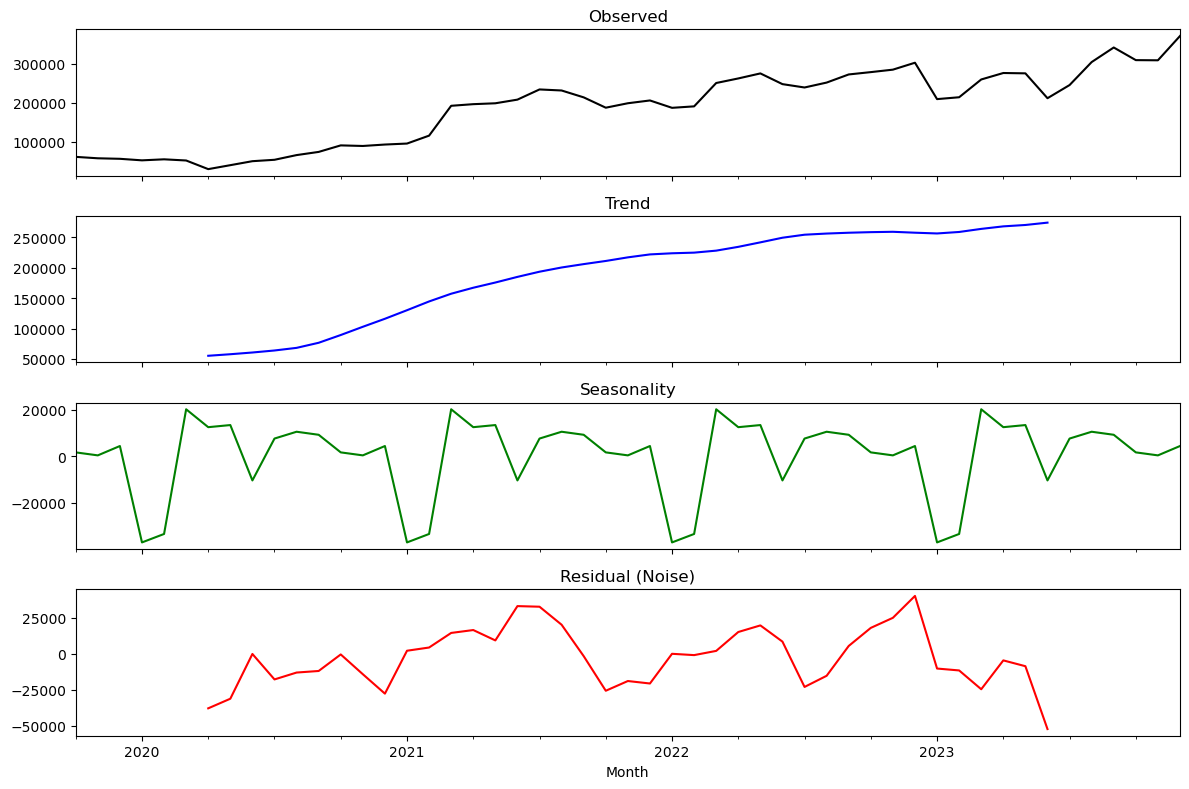

In [8]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure YearDate is a datetime type and set as index
#train_df["Year-Date"] = pd.to_datetime(train_df["Year-Date"])
df_time = train_df.groupby("Year-Date")["Encounter Count"].sum().reset_index()
df_time.set_index("Year-Date", inplace=True)

# Decompose the time series
decomp = seasonal_decompose(df_time["Encounter Count"], model="additive", period=12)  # period=12 for yearly seasonality

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

decomp.observed.plot(ax=axes[0], title="Observed", color='black')
decomp.trend.plot(ax=axes[1], title="Trend", color='blue')
decomp.seasonal.plot(ax=axes[2], title="Seasonality", color='green')
decomp.resid.plot(ax=axes[3], title="Residual (Noise)", color='red')

plt.xlabel("Month")
plt.tight_layout()
plt.show()

Let's try grouping by month to see if there's any patterns that arise from the dataset. This is simply finding the avg encounter count of all rows under the same month. Looks like average encounter count peaks around September and is at lowest in January. 

C:\Users\super\AppData\Local\Temp\ipykernel_5872\2162907735.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Year"] = train_df["Year-Date"].dt.year
C:\Users\super\AppData\Local\Temp\ipykernel_5872\2162907735.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Month"] = train_df["Year-Date"].dt.month
C:\Users\super\AppData\Local\Temp\ipykernel_5872\2162907735.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` v

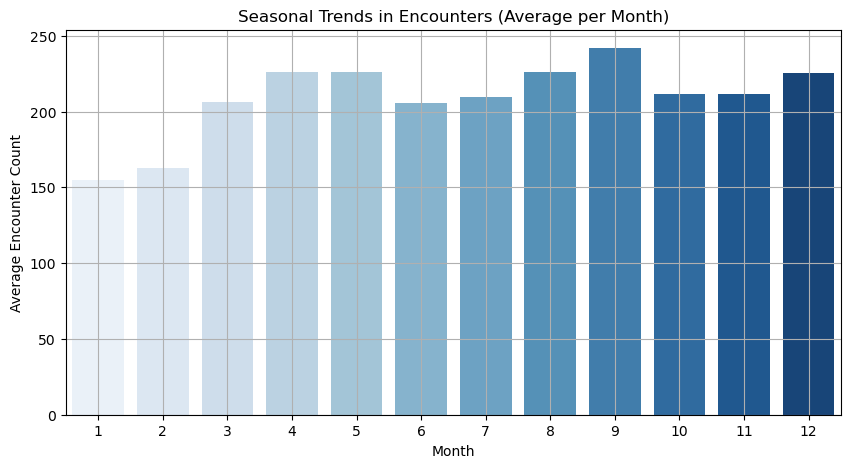

In [9]:
import seaborn as sns

# Extract Month & Year for grouping
train_df["Year"] = train_df["Year-Date"].dt.year
train_df["Month"] = train_df["Year-Date"].dt.month

# Group by Month to see seasonal effects
monthly_avg = train_df.groupby("Month")["Encounter Count"].mean()

# Plot Monthly Seasonality
plt.figure(figsize=(10,5))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette="Blues")
plt.xlabel("Month")
plt.ylabel("Average Encounter Count")
plt.title("Seasonal Trends in Encounters (Average per Month)")
plt.grid(True)
plt.show()


Title 42 appeared to affect a handful of countries, we can take a closer look at total encounter count for these countries. Also threw in Ukraine because noticed a sharp increase in Feb2022 coinciding with Russian invasion, so wanted to see if that was reflected in the data.

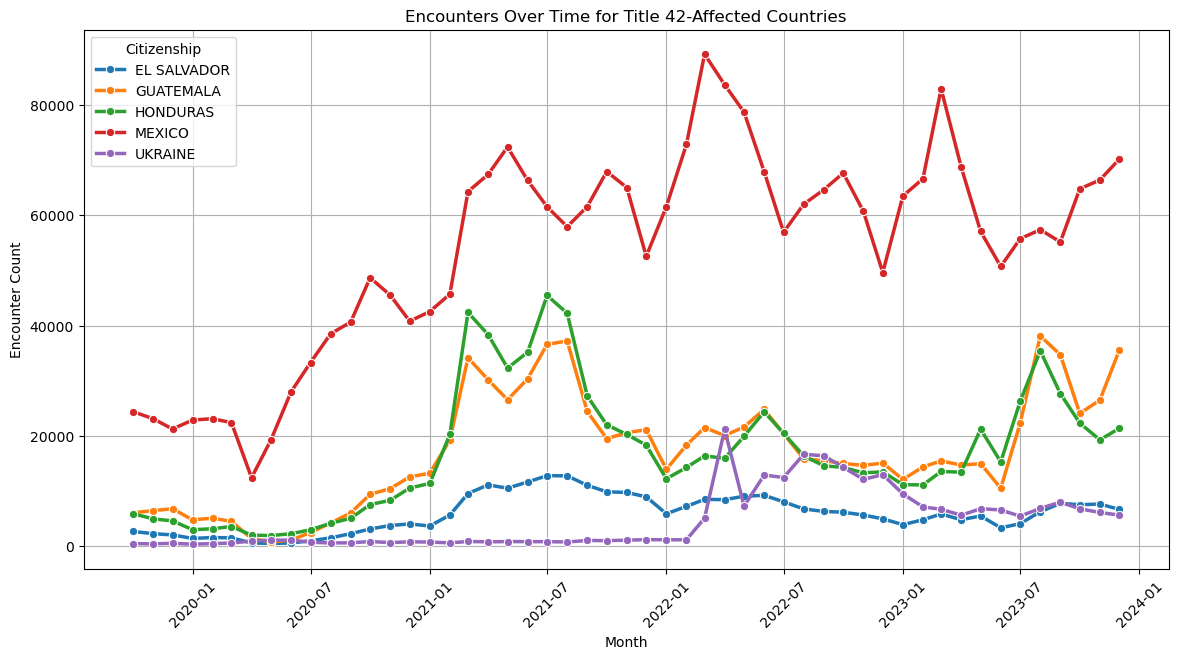

In [10]:
# Define countries of interest
affected_countries = ["UKRAINE", "MEXICO", "GUATEMALA", "HONDURAS", "EL SALVADOR"]

# Filter the dataset for those countries
filtered_data = train_df[train_df["Citizenship"].isin(affected_countries)]

# Aggregate encounters by MonthDate and Citizenship
df_agg = filtered_data.groupby(["Year-Date", "Citizenship"])["Encounter Count"].sum().reset_index()


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,7))

# Plot each country separately
sns.lineplot(data=df_agg, x="Year-Date", y="Encounter Count", hue="Citizenship", marker="o", linewidth=2.5)

# Formatting
plt.xlabel("Month")
plt.ylabel("Encounter Count")
plt.title("Encounters Over Time for Title 42-Affected Countries")
plt.xticks(rotation=45)
plt.legend(title="Citizenship")
plt.grid(True)

plt.show()


We can separate Title 42 encounters from Title 8 to compare for these countries.

In [11]:
# Filter dataset for those countries
filtered_data = train_df[train_df["Citizenship"].isin(affected_countries)]

# Ensure Title of Authority column exists
if "Title of Authority" in filtered_data.columns:
    # Aggregate encounters by MonthDate, Citizenship, and Title of Authority
    df_agg = filtered_data.groupby(["Year-Date", "Citizenship", "Title of Authority"])["Encounter Count"].sum().reset_index()
else:
    print("Column 'Title of Authority' not found in dataset")


# Pivot data to separate Title 8 and Title 42
df_pivot = df_agg.pivot_table(index=["Year-Date", "Citizenship"], 
                              columns="Title of Authority", 
                              values="Encounter Count", 
                              fill_value=0).reset_index()


df_pivot


Title of Authority,Year-Date,Citizenship,Title 42,Title 8
0,2019-10-01,EL SALVADOR,0.0,2656.0
1,2019-10-01,GUATEMALA,0.0,6047.0
2,2019-10-01,HONDURAS,0.0,5878.0
3,2019-10-01,MEXICO,0.0,24391.0
4,2019-10-01,UKRAINE,0.0,464.0
...,...,...,...,...
250,2023-12-01,EL SALVADOR,0.0,6654.0
251,2023-12-01,GUATEMALA,0.0,35544.0
252,2023-12-01,HONDURAS,0.0,21361.0
253,2023-12-01,MEXICO,0.0,70191.0


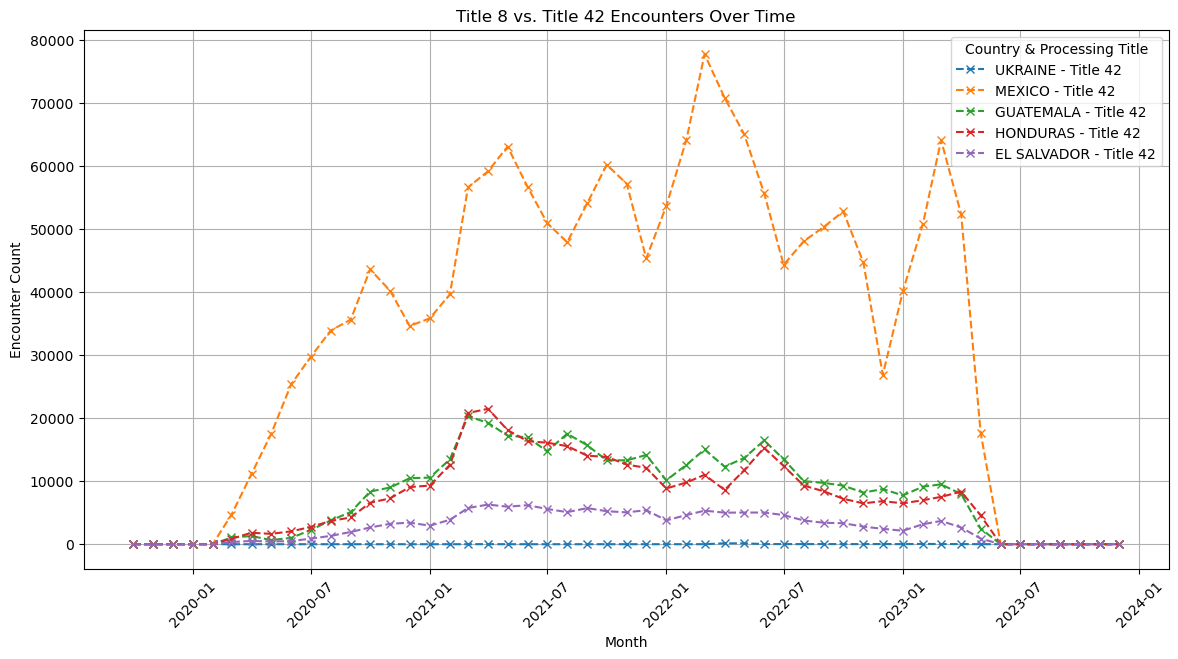

In [12]:
# Rename columns for clarity
df_pivot.columns = ["Year-Date", "Citizenship", "Title 42", "Title 8"]


plt.figure(figsize=(14, 7))

# Plot each country's Title 8 vs Title 42 encounters
for country in affected_countries:
    country_data = df_pivot[df_pivot["Citizenship"] == country]
    #plt.plot(country_data["Year-Date"], country_data["Title 8"], label=f"{country} - Title 8", linestyle='-', marker='o')
    plt.plot(country_data["Year-Date"], country_data["Title 42"], label=f"{country} - Title 42", linestyle='--', marker='x')

# Formatting
plt.xlabel("Month")
plt.ylabel("Encounter Count")
plt.title("Title 8 vs. Title 42 Encounters Over Time")
plt.xticks(rotation=45)
plt.legend(title="Country & Processing Title")
plt.grid(True)

plt.show()


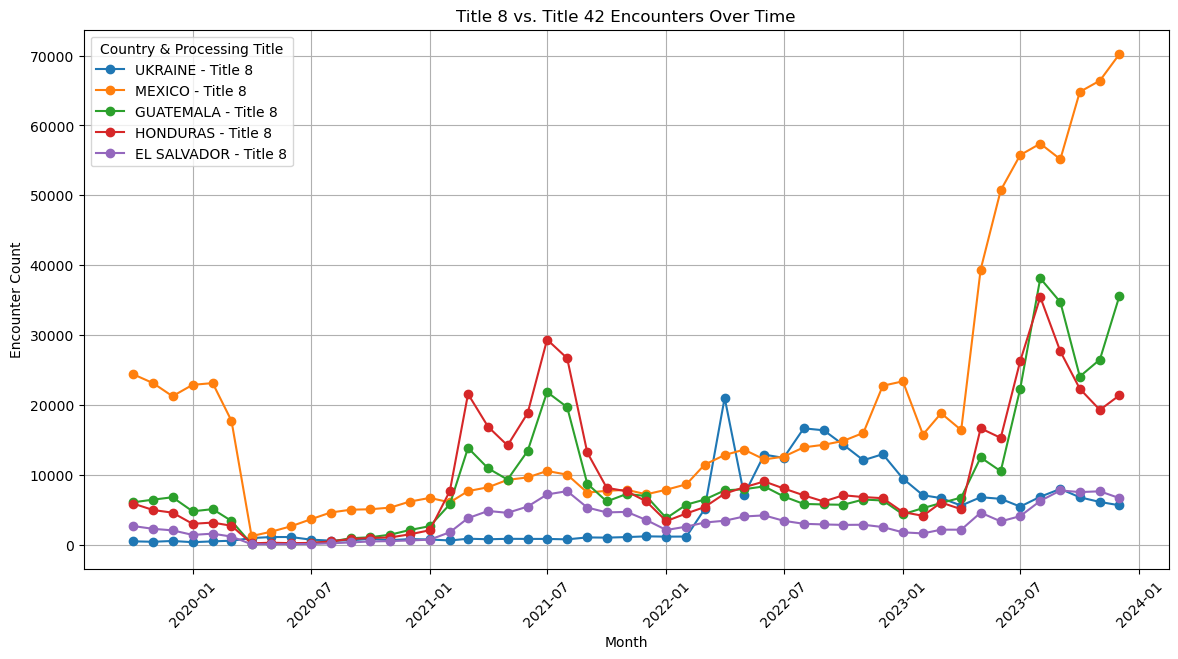

In [13]:
plt.figure(figsize=(14, 7))


for country in affected_countries:
    country_data = df_pivot[df_pivot["Citizenship"] == country]
    plt.plot(country_data["Year-Date"], country_data["Title 8"], label=f"{country} - Title 8", linestyle='-', marker='o')
    #plt.plot(country_data["Year-Date"], country_data["Title 42"], label=f"{country} - Title 42", linestyle='--', marker='x')

# Formatting
plt.xlabel("Month")
plt.ylabel("Encounter Count")
plt.title("Title 8 vs. Title 42 Encounters Over Time")
plt.xticks(rotation=45)
plt.legend(title="Country & Processing Title")
plt.grid(True)

plt.show()

Closer look at Ukraine! See that spike starting in Feb2022?

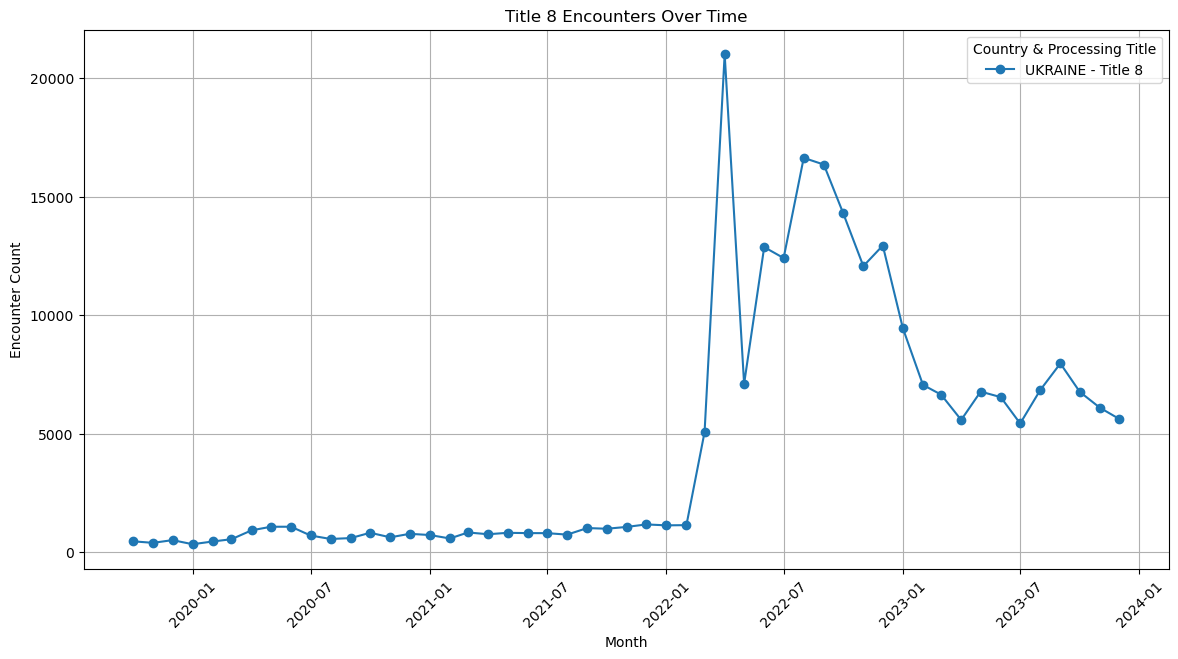

In [14]:
plt.figure(figsize=(14, 7))

affected_countries = ["UKRAINE"]

for country in affected_countries:
    country_data = df_pivot[df_pivot["Citizenship"] == country]
    plt.plot(country_data["Year-Date"], country_data["Title 8"], label=f"{country} - Title 8", linestyle='-', marker='o')
    #plt.plot(country_data["Year-Date"], country_data["Title 42"], label=f"{country} - Title 42", linestyle='--', marker='x')

# Formatting
plt.xlabel("Month")
plt.ylabel("Encounter Count")
plt.title("Title 8 Encounters Over Time")
plt.xticks(rotation=45)
plt.legend(title="Country & Processing Title")
plt.grid(True)

plt.show()

IN PROGRESS (NOT WORKING): Trying to recreate this figure: 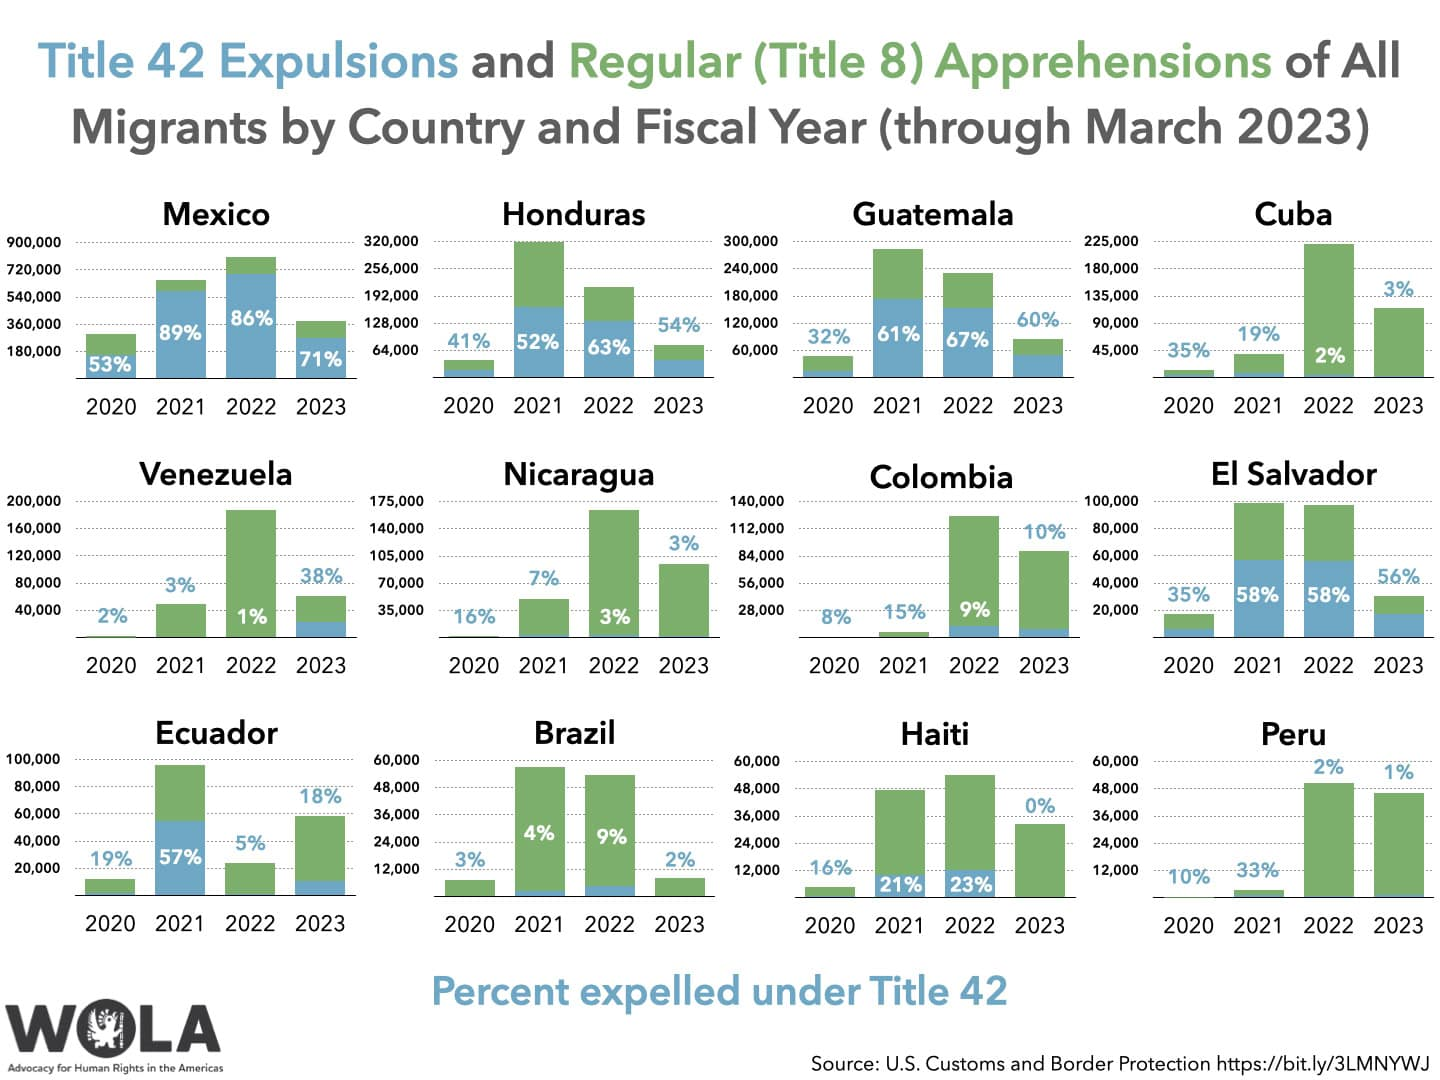

Title of Authority Fiscal Year  Citizenship  Title 42   Title 8
0                         2024       BRAZIL       0.0    9194.0
1                         2024     COLOMBIA       0.0   49146.0
2                         2024         CUBA       0.0   63184.0
3                         2024      ECUADOR       0.0   43181.0
4                         2024  EL SALVADOR       0.0   21789.0
5                         2024    GUATEMALA       0.0   86086.0
6                         2024        HAITI       0.0   62018.0
7                         2024     HONDURAS       0.0   62936.0
8                         2024       MEXICO       0.0  201405.0
9                         2024    NICARAGUA       0.0   31632.0
10                        2024         PERU       0.0   15042.0
11                        2024    VENEZUELA       0.0  148045.0
12                        2020       BRAZIL     268.0    8879.0
13                        2020     COLOMBIA      56.0    2712.0
14                        2020         C

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

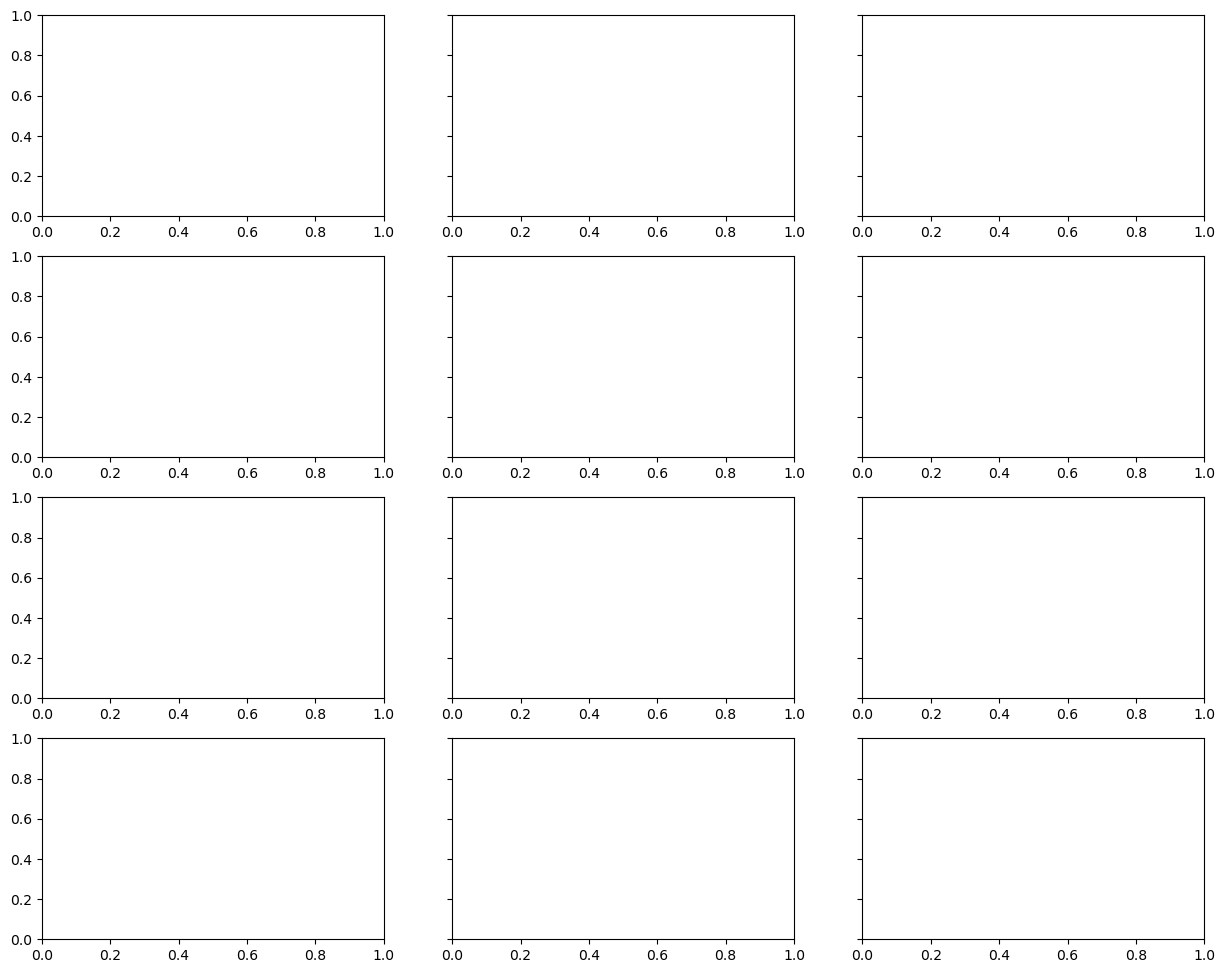

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define affected countries
affected_countries = ["MEXICO", "HONDURAS", "GUATEMALA", "CUBA", "VENEZUELA",
                      "NICARAGUA", "COLOMBIA", "EL SALVADOR", "ECUADOR", "BRAZIL",
                      "HAITI", "PERU"]

# Filter data for selected countries
filtered_data = train_df[train_df["Citizenship"].isin(affected_countries)]

# Aggregate encounter counts by Year-Date, Citizenship, and Title of Authority
df_agg = filtered_data.groupby(["Fiscal Year", "Citizenship", "Title of Authority"])["Encounter Count"].sum().reset_index()

# Pivot the data to get Title 8 and Title 42 encounters in separate columns
df_pivot = df_agg.pivot_table(index=["Fiscal Year", "Citizenship"], 
                              columns="Title of Authority", 
                              values="Encounter Count", 
                              fill_value=0).reset_index()

print(df_pivot)

# Rename columns for clarity
df_pivot.columns = ["Fiscal Year", "Citizenship", "Title 42", "Title 8"]

# Convert "Year-Date" to a datetime type for correct plotting
#df_pivot["Year-Date"] = pd.to_datetime(df_pivot["Year-Date"])

# Create subplots for each country
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharey=True)
axes = axes.flatten()

for i, country in enumerate(affected_countries):
    ax = axes[i]
    
    # Filter data for the country
    country_data = df_pivot[df_pivot["Citizenship"] == country]
    
    # Stacked bar chart
    ax.bar(country_data["Fiscal Year"], country_data["Title 8"], label="Title 8 (Regular)", color="green")
    ax.bar(country_data["Fiscal Year"], country_data["Title 42"], bottom=country_data["Title 8"], label="Title 42 (Expulsions)", color="blue")

    # Formatting
    ax.set_title(country)
    ax.set_xticks(country_data["Fiscal Year"])
    #ax.set_xticklabels(country_data["Fiscal Year"].dt.strftime('%Y-%m'), rotation=45)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()
fig.legend(["Title 8", "Title 42"], loc="upper right", bbox_to_anchor=(1.15, 1))
plt.suptitle("Title 42 Expulsions and Title 8 Apprehensions by Country and Fiscal Year", fontsize=14, y=1.05)

# Show plot
plt.show()